In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

## create basis & function demo

In [3]:
np.random.seed(1234567)

In [4]:
def simulate_random_dag(d: int,
                        degree: float,
                        w_range: tuple = (1.0, 1.0)) -> nx.DiGraph:
    """Simulate random DAG with an expected degree by Erdos-Renyi model.
        
        Args:
        d: number of nodes
        degree: expected node degree, in + out
        w_range: weight range +/- (low, high)
        
        Returns:
        G: weighted DAG
        """
    prob = float(degree) / (d - 1)
    B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    
    # remove all in-edges (from precedent nodes) of the first node as A
    W[:, 0] = 0
    # remove all out-edges (from descendent nodes) of the last node as Y
    W[d-1, :] = 0
    # the remained nodes are the mediators M; and reset mediators if it has higher topological order than A or lower order than Y.
    ordered_vertices = list(nx.topological_sort(nx.DiGraph(W)))
    j = 1
    while j < d - 1:
        if  ordered_vertices.index(j) < ordered_vertices.index(0):
            W[j, 1:(d - 1)] = np.zeros (d - 2)
        if  ordered_vertices.index(j) > ordered_vertices.index(d - 1):
            W[1:(d - 1), j] = np.zeros (d - 2)
        j = j + 1
    #print("True weighted adjacency matrix B:\n", W)
    G = nx.DiGraph(W)
    calculate_effect(W)
    return W

In [5]:
import math 
def cos(x):
    return math.cos(x/30*math.pi)*0.8

t: [ 0.    0.    0.   24.75 49.5  74.25 99.   99.   99.  ]
c: [ 1.05193047 -0.07521622 -1.01451101  1.50760532 -1.34214766 -0.4623413
  0.          0.          0.        ]
k: 2



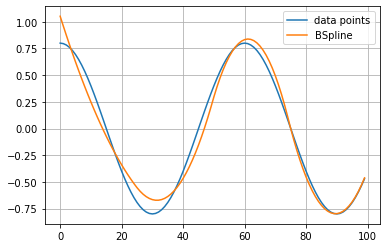

In [6]:
degree =2
x = np.array(range(0, 100))
y = np.array([cos(i) for i in x])
z= [cos(i/10) for i in np.array(range(0, 1100))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

In [7]:
from scipy.interpolate import BSpline
k = 2
t = t
c1 = [1,0,0,0,0,0]
c2 = [0,1,0,0,0,0]
c3 = [0,0,1,0,0,0]
c4 = [0,0,0,1,0,0]
c5 = [0,0,0,0,1,0]
c6 = [0,0,0,0,0,1]
spl1 = BSpline(t, c1, k)
spl2 = BSpline(t, c2, k)
spl3 = BSpline(t, c3, k)
spl4 = BSpline(t, c4, k)
spl5 = BSpline(t, c5, k)
spl6 = BSpline(t, c6, k)

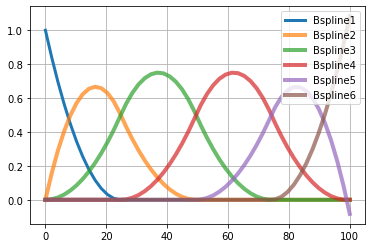

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xx = np.linspace(0, 100, 50)
ax.plot(xx, spl1(xx), lw=3, label='Bspline1')
ax.plot(xx, spl2(xx), lw=4, alpha=0.7, label='Bspline2')
ax.plot(xx, spl3(xx), lw=4, alpha=0.7, label='Bspline3')
ax.plot(xx, spl4(xx), lw=4, alpha=0.7, label='Bspline4')
ax.plot(xx, spl5(xx), lw=4, alpha=0.7, label='Bspline5')
ax.plot(xx, spl6(xx), lw=4, alpha=0.7, label='Bspline6')
ax.grid(True)
ax.legend(loc='best')
plt.show()

## create data

In [10]:
def data_create(seed,time_stamp,sample__time):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  #y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x]) #generate coefficient
  y = np.array([cos(i)for i in x]) #generate coefficient
  base_DAG=np.zeros((5, 5))
  base_DAG[0,4]=y[0]##edited to be coeffcient with error
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,sample__time, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[0,4]=y[i]
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,sample__time, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
  return X_all

In [11]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random

import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed
import time

In [ ]:
n_var=5
n_times=30 #no. of replicates
time_stamp=100 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,1).reshape(sample__time*time_stamp,n_var) #create data
  if replicate==0:
    X_total=X_all.copy()
  else:
    X_total=np.append(X_total,X_all,axis=0)
#np.savetxt("cos_30_100.csv", X_total.T, delimiter=",")

# new method

In [12]:
# ----------- Configurations:
time_stamp=100
n_timestamp=time_stamp
sample__time=1##sample per timepoint
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = n_var # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [13]:
n_timestamp

100

In [14]:
sample__time

1

In [15]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time*time_stamp, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_column=np.zeros((sample__time*time_stamp, n_var,1))#for each spline
        for i in range(0,n_timestamp):
            D_column[(sample__time*i):(sample__time*(i+1)),:,:]=X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#X_i *f(i), stack horizontally
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_column
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [16]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5,spl6]

In [17]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [18]:
# ----------- Configurations:
n = sample__time*time_stamp # The number of samples of data.
d = 36 # The number of variables in data after spline.  (p+1*k)
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [19]:
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:,:p]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0]))+sum(sum(abs(B[p:, p:]))) # uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [20]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [54]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            #h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            h1_B =0
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:,:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [56]:
sample__time=1
n_var=5
n_times=30 #no. of replicates
time_stamp=100 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp,n_var,n_var))
lambda_list=np.zeros((n_times,30,n_var))
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
time_list_new=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,sample__time) #create data
  D=create_D(X_all,spline_list)
  data_all=np.append(X_all,D, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = sample__time*time_stamp # The number of samples of data.
  d = 36 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=6 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              #h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              h1_B=0 
              for i in range(n_timestamp):
                  #aa=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p),B_new[p:,:p]))#acyclity on Gamma
                  #print(aa)
                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:,:p].type(torch.FloatTensor))))
                  #h1_B=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),B_new[p:,:p].type(torch.FloatTensor)))#acyclity on Gamma
              h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top
              #B_trans_new=torch.transpose(B_new, 0, 1)
              #h1_B = fun_h1_B(B_trans_new[p:,p:]) #acyclity on G
              #h1_B = fun_h1_B(B_new[p:,:p]) #edited acyclity on G
              #h2_B = fun_h3_B(B_new) ##handle the zero

              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:,:(p)]
  lambda_list[replicate,::]=pred_gamma
  np.save("cos_100_30_gamma",lambda_list)
  def matrix_gen(t):
    output,identity=spl_consraint(spline_list,t,p)
    return torch.matmul(identity.type(torch.FloatTensor),torch.from_numpy((np.multiply(output.numpy(),pred_gamma))).type(torch.FloatTensor)).T
  #estimated_coefficient=[matrix_gen(i)[4,0].item() for i in range(time_stamp)]
  #average_coef_list_new[replicate,:]=estimated_coefficient

  ## FDR, TPR, SHD for  new method
  FDR_list_piece_new=[]
  TPR_list_piece_new=[]
  SHD_list_piece_new=[]
  base_DAG=np.zeros((5, 5))
  for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.3]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      average_coef_list_new[replicate,i,:,:]=matrix_gen(i).numpy()
      a=matrix_gen(i).numpy()
      a[abs(a)<0.3] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)
    
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
  np.save("cos_100_30",average_coef_list_new)
  FDR_total_new.append(mean(FDR_list_piece_new))
  TPR_total_new.append(mean(TPR_list_piece_new))
  SHD_total_new.append(mean(SHD_list_piece_new))
  timeend_new=time.time()
  time_list_new.append(timeend_new-timestart_new)
  print(timeend_new-timestart_new)
  ###write csv
  df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df_new["FDR"]=FDR_total_new
  df_new["TPR"]=TPR_total_new
  df_new["SHD"]=SHD_total_new
  df_new["time"]=time_list_new
  #df_new.to_csv("cos_new_5.csv")
  print(replicate)


(100, 35, 1)


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0008500401584530532
Best NLL Loss : 1.5126714194703092e-06
Best MSE Loss : 8.643836682687483e-08
5754.160809993744
0
(100, 35, 1)
Best ELBO Loss : 0.0006408366815012314
Best NLL Loss : 1.378544929583801e-06
Best MSE Loss : 7.877399597621721e-08
5648.004980325699
1
(100, 35, 1)
Best ELBO Loss : 0.0006831137796381573
Best NLL Loss : 2.3351157131302394e-06
Best MSE Loss : 1.3343518360744222e-07
5179.1868505477905
2
(100, 35, 1)
Best ELBO Loss : 0.0006829012225027405
Best NLL Loss : 4.270695636051324e-06
Best MSE Loss : 2.4403975063150414e-07
5181.956488609314
3
(100, 35, 1)
Best ELBO Loss : 0.0006990416715792842
Best NLL Loss : 8.11245471629916e-06
Best MSE Loss : 4.6356884093138064e-07
5643.52001285553
4
(100, 35, 1)
Best ELBO Loss : 0.0008365637624988453
Best NLL Loss : 2.5159604078562904e-06
Best MSE Loss : 1.4376916616321662e-07
5179.527011156082
5
(100, 35, 1)
Best ELBO Loss : 0.00100130858957776
Best NLL Loss : 4.117531661705575e-06
Best MSE Loss : 2.3528752352603

In [58]:
result_new=np.load("cos_100_30.npy") #0 axis is the number of replicates
mat_result=pd.read_csv("simulate_100/matresult_30_100_nocons.csv",header=None)

In [59]:
n_times=30
p=5
gamma=np.load("cos_100_30_gamma.npy")
def matrix_gen_next(t,pred_gamma):
    output,identity=spl_consraint(spline_list,t,p)
    return torch.matmul(identity.type(torch.FloatTensor),torch.from_numpy((np.multiply(output.numpy(),pred_gamma))).type(torch.FloatTensor)).T
next_list=[]
for i in range(n_times):
    next_list.append(matrix_gen_next(time_stamp,gamma[i])[4,0].numpy().item())


In [60]:
time_stamp

100

In [61]:
np.square([(i-cos(time_stamp)) for i in next_list]).mean() ##MSE for next step

0.4539192202381962

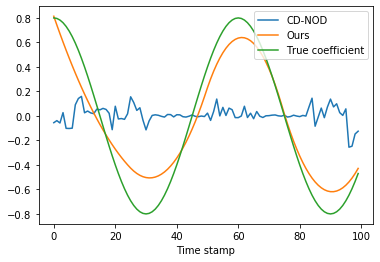

In [63]:
import matplotlib.pyplot as plt
time_stamp=100
#plt.plot(range(time_stamp),result_ANOCA[:,:,0,4].mean(axis=0))
plt.plot(range(time_stamp),mat_result.to_numpy().reshape(5,5,100,30)[4,0,:,:].mean(axis=1))
plt.plot(range(time_stamp),result_new[:,:,4,0].mean(axis=0))
plt.plot(range(time_stamp),[cos(i) for i in range(time_stamp)])

# Function add a legend  
plt.legend(["CD-NOD","Ours", "True coefficient"])
  
# function to show the plot
plt.xlabel("Time stamp")
# function to show the plot
plt.savefig('cos_T=100.pdf')

In [54]:
#CDNOD
diff_list_mat=mat_result.to_numpy().reshape(5,5,100,30)[4,0,:,:].T-[cos(i) for i in range(time_stamp)]
#MSE 
np.square(diff_list_mat).mean()


0.40600064021098453

In [55]:
np.square(diff_list_mat).mean(axis=1).std()/math.sqrt(30)

0.010559536143876058

In [56]:
#proposed
diff_list_new=result_new[:,:,4,0]-[cos(i) for i in range(time_stamp)]
np.square(diff_list_new).mean() ##MSE

0.034006193078545736

In [57]:
np.square(diff_list_new).mean(axis=1).std()/math.sqrt(30)

0.0025065985470622584

In [51]:
base_DAG=np.zeros((5, 5))
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(n_times):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_new[replicate,i,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.009667
TPR    0.935000
SHD    0.074667
dtype: float64

In [52]:
df_new.std()/np.sqrt(30)

FDR    0.001761
TPR    0.003243
SHD    0.002826
dtype: float64

In [49]:
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      #a=result_ANOCA[replicate,i,:,:]
      a=mat_result.iloc[:,(replicate*100+i*5):(replicate*100+i*5+5)].to_numpy()
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.766795
TPR    0.343333
SHD    3.088000
dtype: float64

In [50]:
df.std()/np.sqrt(30)

FDR    0.024592
TPR    0.034242
SHD    0.222125
dtype: float64